## ASTR 310 HW 12

### 1) Exoplanet light curve fitting


The Kepler satellite detected planets by observing $\sim$ 150,000 stars over a period of about 9 years and looking for brief drops in the amount of light coming from the stars. The drops in the stars' light curves (when confirmed as being due to a planet) occurred because planets in orbit around the stars transited them, partially blocking their light output for a time.

**a)** Download the file `kplr010264660-2009131105131_llc.fits` from the course page. This is a FITS file containing Kepler observations of the star 2MASS J19105011+4719589 (Kepler 14), with a transit indicating the presence of the planet Kepler 14b. The FITS file contains a binary table extension HDU that holds the light curve data. Write Python code to read the file and extract the data columns TIME, SAP_FLUX, and SAP_FLUX_ERR. These contain, respectively, the observation time (in units of barycenter-corrected Julian date $-$ 2454833), the stellar flux, and the error in the stellar flux, both measured in electrons s $^{-1}$.

In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.optimize import curve_fit, root
from scipy.constants import G
hdulist = fits.open("kplr010264660-2009131105131_llc.fits")
t = Table(hdulist[1].data)
TIME = t["TIME"].data
SAP_FLUX = t["SAP_FLUX"].data
SAP_FLUX_ERR = t["SAP_FLUX_ERR"].data



**b)** Select the times between BJD ${-}$ 2454833 = 123.5 and 125.5 days and mask out any NaN values (you can use the `numpy.isnan()` function in your Boolean mask expression).  Plot the flux versus time, including error bars and appropriate axis labels.

Text(0, 0.5, 'Flux (Electron* s $^{-1}$)')

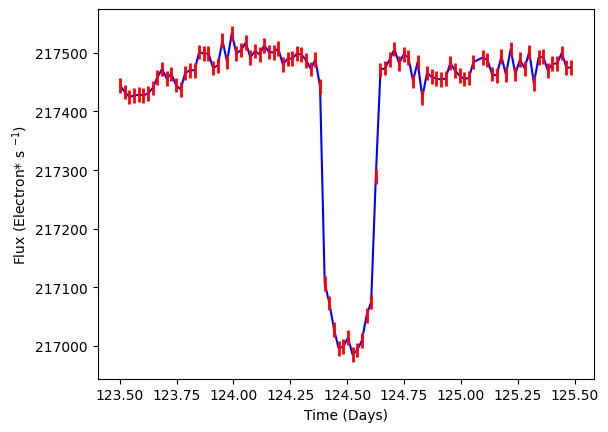

In [2]:
BJDmask = (TIME > 123.5) & ((TIME ) < 125.5) & (~np.isnan(TIME))

BJD = TIME[BJDmask]
FLUX = SAP_FLUX[BJDmask]
nanMask = ~np.isnan(FLUX)
FLUX = FLUX[nanMask]
ERR = SAP_FLUX_ERR[BJDmask]
ERR = ERR[nanMask]

BJD = BJD[nanMask]
import matplotlib.pyplot as plt
plt.plot(BJD,FLUX, label = "Stellar Flux",c='blue')
plt.errorbar(BJD,FLUX,yerr=ERR,c='red',fmt='none',elinewidth=2)
plt.xlabel("Time (Days)")
plt.ylabel("Flux (Electron* s $^{-1}$)")


**c)**  Use SciPy to fit the light curve using the function

$$ F(t) = 
\begin{cases}
F_0[1 + 4f\frac{t-t_b}{\tau}(\frac{t-t_b}{\tau}-1)] & 0 \leq t-t_b \leq \tau \\
F_0 & \text{otherwise.}
\end{cases}
$$

Here $F_0$ is the uneclipsed stellar flux, $f$ is the fractional light reduction at maximum eclipse, $t_b$  is the beginning time for the eclipse, and $\tau$ is the duration of the eclipse. 

***i)*** Plot the best-fit light curve model on top of the data. 

***ii)*** Report the best-fit values of $F_0$, $f$, $t_b$, and $\tau$, along with their uncertainties. 

***iii)*** Compute the reduced $\chi^2$ value and comment qualitatively on the goodness of fit.

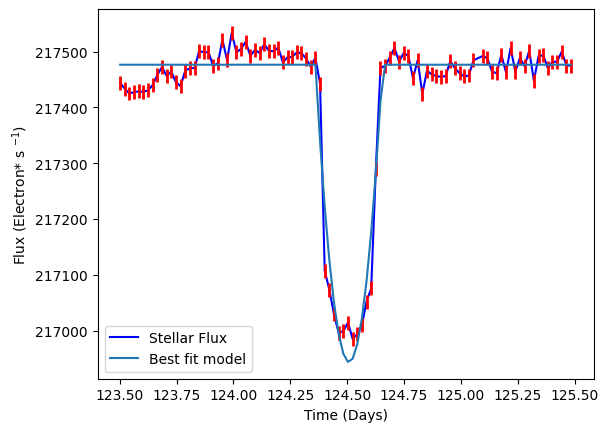

Flux best fit: 217476.33764958815 with error 3.591354621427707
Fractional reduction best fit: 0.0024509435676093394 with error 6.268330927355662e-05
Tb best fit: 124.36034733145739 with error 0.004251295929371273
Tau best fit: 0.295299066321717 with error 0.0065962737426025885
Reduced Chi-Squared: 0.45808929511488805
This implies a good fit, with little error and a value of Chi-Squared below one.


In [3]:
from scipy.optimize import curve_fit
fr = 0.00229
tb = 124.375
tau = .5
F0 = 217500
guess = [F0,tb,fr,tau]
def f(t,F0,tb,fr,tau):

    return np.where(np.logical_and((t-tb) >= 0,(t-tb) <= tau ),F0*(1+4*fr*((t-tb)/tau)*(((t-tb)/tau) - 1)), F0)


popt,pcov = curve_fit(f,BJD,FLUX,p0=guess)

import matplotlib.pyplot as plt
plt.plot(BJD,FLUX, label = "Stellar Flux",c='blue')
plt.errorbar(BJD,FLUX,yerr=ERR,c='red',fmt='none',elinewidth=2)
plt.xlabel("Time (Days)")
plt.ylabel("Flux (Electron* s $^{-1}$)")

Fluxfit, tbfit, fluxreductfit, taufit = popt
Fluxerr, tberr, fluxreducterr, tauerr = np.sqrt(np.diag(pcov))

modelflux = f(BJD,Fluxfit,tbfit,fluxreductfit,taufit)
plt.plot(BJD,modelflux,label = "Best fit model")
plt.legend()
plt.show()
print("Flux best fit:",Fluxfit, "with error",Fluxerr)
print("Fractional reduction best fit:",fluxreductfit, "with error",fluxreducterr)
print("Tb best fit:",tbfit, "with error",tberr)
print("Tau best fit:",taufit, "with error",tauerr)

chisqrd = np.sum(((FLUX-modelflux)**2)/modelflux)
print("Reduced Chi-Squared:",chisqrd)
print("This implies a good fit, with little error and a value of Chi-Squared below one.")


### 2) Orbital Mechanics

You find yourself adrift (with zero velocity) in a spacecraft a distance $r_0 = 10 R_{Merc}$ from the planet Mercury, which has a mass $M_{Merc} \approx 3.285\times 10^{26}$ g and radius $R_{Merc} \approx 2.440\times 10^{8}$ cm. If you do nothing, you'll crash onto the surface.  However, you do have a bit of fuel remaining, so your task is to figure out how to get yourself into an orbit whose perihermion (closest approach to Mercury) is greater than the radius of Mercury itself.

From orbital mechanics class you know that, if you had a speed $v_0$ oriented at an angle $\theta$ to your radius vector from Mercury, you would find yourself on a Keplerian orbit with perihermion equal to
$$ r_\mathrm{min} = a(1-e),$$
which you can compute as follows.  The specific energy (energy per unit mass) of the orbit is
$$ E/m = \frac{1}{2} v_0^2 - \frac{GM_{Merc}}{r_0} = -\frac{GM_{Merc}}{2a}, $$
which gives the semi-major axis $a$.  The specific angular momentum (per unit mass) is 
$$ L/m = \vec{r}\times \vec{v} = r_0 v_0 \sin \theta.$$
The eccentricity of the orbit comes from 
$$e^2 = 1 + \frac{2EL^2}{G^2 M^2 m^3} = 1 + \frac{2}{G^2M^2}\biggl(\frac{E}{m}\biggr)\biggl(\frac{L}{m}\biggr)^2.$$


You need to briefly fire the engines to put yourself on an orbit such that $r_\mathrm{min} \geq R_{Merc}$ and you don't crash into Mercury. To do that you need to determine $v_0$ and $\theta,$ and to conserve fuel, you need to find the minimum speed that will work.

**a)** Write a Python function to use with `scipy.optimize.root()` to find the necessary $v_0$ to make $r_\mathrm{min} = R_{Merc}$ for a given value of $\theta$.

In [4]:
M = 3.285e26
R = 2.44e8
r0 = 10*R
G_cm = G * 1e3

def f(v0, theta):
    E_m = 0.5 * v0**2 - G_cm * M / r0
    a = -G_cm * M/ (2 * E_m)
    L_m = r0 * v0 * np.sin(theta)
    e = np.sqrt(1+(2/(G_cm*M)**2)*E_m*L_m**2)
    rmin = a * (1 - e)
    return rmin - R

**b)** For the root finder in the next part, you'll need an initial guess for $v_0$. 
You can obtain a reasonable initial guess as follows.  
First calculate the circular velocity at the surface of Mercury, $v_c = \sqrt{GM_{Merc}/R_{Merc}}.$ Choose $\theta = 0.5$ radian and calculate $r_\mathrm{min}$ for a range of $v_0$ values from 0 to 5 times that circular speed.  Plot $r_\mathrm{min}-R_{Merc}$ vs $v_0$ and use the plot to estimate a reasonable starting guess value for $v_0.$


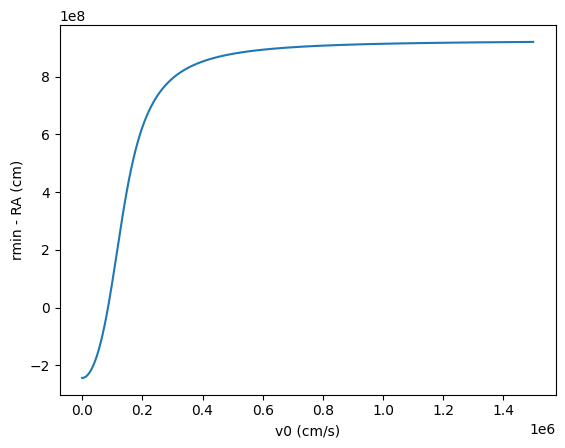

87017.80923641563

In [5]:
vc = np.sqrt(G_cm*M/R)
v0_values = np.linspace(0, 5 * vc, 1000)
rmin_RA = np.array([f(v0, 0.5) for v0 in v0_values])
plt.plot(v0_values, rmin_RA)
plt.xlabel('v0 (cm/s)')
plt.ylabel('rmin - RA (cm)')
plt.show()
vals = np.where(rmin_RA >= 0)
v0_RA = v0_values[vals[0][0]]
v0_RA

**c)** Set up an array of 1000 $\theta$  values between 0 and $2\pi$. For each value, use the `root` function to find the minimum $v_0$ to avoid a crash. Plot the $v_0$ values versus $\theta$, for those cases in which the root finder was successful -- some  values will not admit a solution. Remember to use appropriate axis labels. 

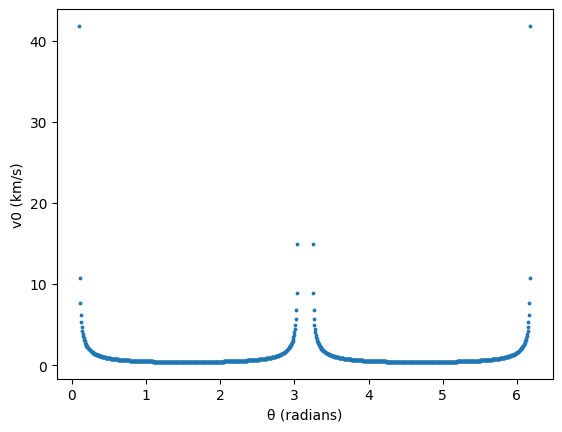

In [6]:
theta_values = np.linspace(0, 2 * np.pi, 1000)
v0_success = []
theta_success = []
for theta in theta_values:
    sol = root(f, v0_RA, args=(theta))
    if sol.success:
        v0_success.append(sol.x[0])
        theta_success.append(theta)
plt.scatter(np.array(theta_success), np.array(v0_success) / 1e5,s=3)
plt.xlabel('θ (radians)')
plt.ylabel('v0 (km/s)')
plt.show()

**d)** Report the $\theta$ value that allowed for the smallest $v_0$ and that $v_0$ value in km/s.

In [7]:
min_index = np.argmin(v0_success)
theta_min_v0 = theta_success[min_index]
v0_min = v0_values[min_index]
print(f"θ value that allowed for the smallest v0: {theta_min_v0} radians")
print(f"Smallest v0: {v0_min / 1e5} km/s")

θ value that allowed for the smallest v0: 1.5723686954903868 radians
Smallest v0: 3.510718510572631 km/s
